## This script replicates Figures 1-10 and Table 1 in Redding (2016, JIE) using Python packages

In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

import random

In [2]:
from utils.graydist import graydist_quasi_euclidean
import utils.region_utils as utils

In [3]:
# Generate a 11 by 11 regions
N = 11
# 121 regions in total
NN = N**2
# Total fixed labor
LL = 153889

# Attribute each region with a psedu longitude and latitude
ltd = np.linspace(0,4,N)
lgd = np.linspace(0,4,N)

# endowed trading frictions 
tt0 = 7.9
# trading frictions with transport infrastructure
tt1 = 1.
tau0 = np.array([tt0]*NN).reshape(11,-1)
tau1 = tau0.copy()
tau1[:,5] = tt1
tau1[5,:] = tt1


# Observed trading cost
dist0 = np.zeros(shape = (NN,NN))

# Counterfactual trading cost: Construct a highway across several regions
dist1 = dist0.copy()

for i in range(N):
    for j in range(N):
        seed = np.zeros_like(tau0,dtype = bool)
        seed[i,j] = 1
        temp = graydist_quasi_euclidean(tau0,seed)
        dist0[i*N + j] = temp.ravel()
        temp = graydist_quasi_euclidean(tau1,seed)
        dist1[i*N + j] = temp.ravel()
        
        
        
for i in range(NN):
    dist0[i,i] = 1.
    dist1[i,i] = 1.
    
    
treat = tau1.copy()
treat = (treat==1).astype(int).reshape(-1,1)

rdist = dist1/dist0

# Parameterize trade cost
dist0=dist0**0.33;
dist1=dist1**0.33;


In [4]:
# set parameters

In [5]:
alpha = .75
sigma = 4
Hsigma = 5
theta = 4
epsilon = 3
params = [alpha, theta, epsilon]

In [6]:
# Specify local fundamentals

In [7]:
# productivity A
a = np.exp(np.random.normal(0,1,NN))
a = (a/scipy.stats.gmean(a)).reshape(-1,1)

# Amenity B
b = np.exp(np.random.normal(0,1,NN))
b = (b/scipy.stats.gmean(b)).reshape(-1,1)

# land 
H = np.array([100]*NN).reshape(-1,1)

# Fundamentals
funds = [a, b, H]

# fixed cost
F = 1

In [8]:
## Solve endogenous variables...

In [9]:
L0,w0,pi0 = utils.solve_lw(params, funds, NN, dist0, LL,error=1e-9)

Current iteration: 100
Unique solution found......


In [10]:
L1,w1,pi1 = utils.solve_lw(params, funds, NN, dist1, LL,error = 1e-9)

Current iteration: 100
Unique solution found......


In [11]:
P0 = utils.price_index([alpha,theta,sigma], funds,pi0,w0)
P1 = utils.price_index([alpha,theta,sigma], funds,pi1,w1)

In [12]:
# land rent

In [13]:
r0 = utils.land_rent(alpha, H, w0,L0)
r1 = utils.land_rent(alpha, H, w1,L1)

In [14]:
pseudo_u = utils.pseudo_pwelfare([alpha, theta], pi0,pi1)

In [15]:
realw0 = utils.real_wage(alpha, w0,P0, r0)
realw1 = utils.real_wage(alpha, w1,P1, r1)

In [16]:
fig4data = pd.DataFrame(np.concatenate([L1/L0,realw1/realw0, P1/P0, w1/w0, r1/r0, pseudo_u.reshape(-1,1), treat.reshape(-1,1)],axis=1), 
                       columns=['Population','Real Wage','Price Index', 'Wage','Land Rents','Incorrect Immobile Welfare','treat'])

<Axes: xlabel='Incorrect Immobile Welfare', ylabel='Probability'>

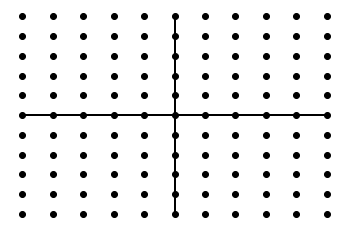

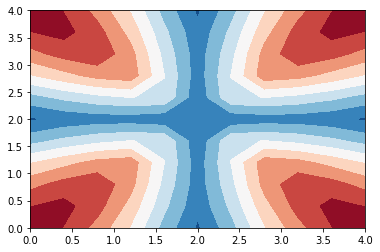

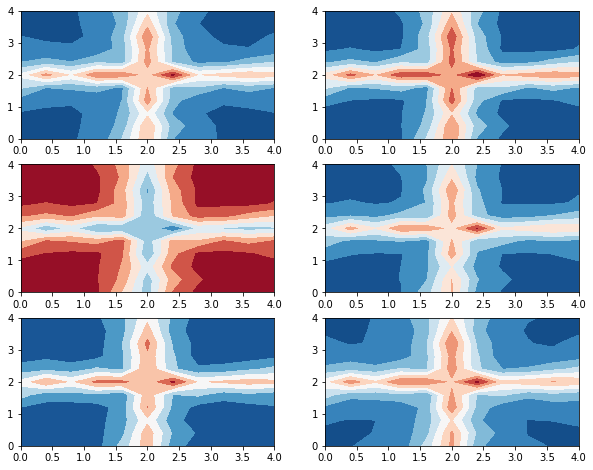

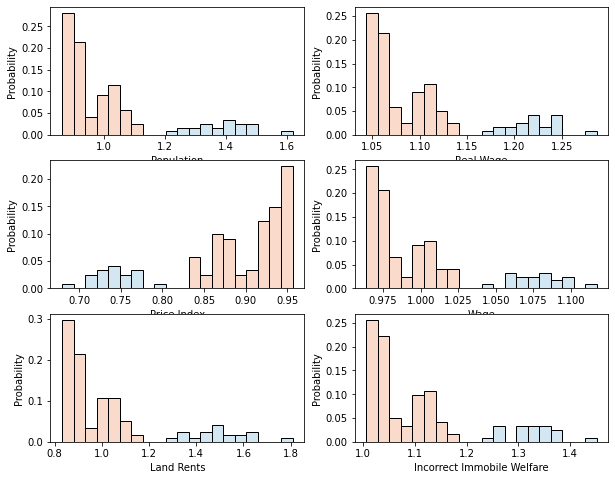

In [18]:
# replicate Figure 1
x,y = np.meshgrid(ltd,lgd)
_,ax = plt.subplots()
ax.scatter(x=x,y =y,color = 'k')
ax.vlines(x = 2, ymin = 0, ymax = 4,color = 'k', linewidth = 2)
ax.hlines(y = 2, xmin = 0, xmax = 4,color = 'k',linewidth = 2)
ax.axis("off")

# replicate Figure 2

_,ax = plt.subplots()
ax.contourf(x,y,rdist.mean(axis=0).reshape(N,N),cmap = 'RdBu_r')


# replicate Figure 3.

_,ax = plt.subplots(3,2,figsize=(10,8))
ax[0,0].contourf(x,y,(L1/L0).reshape(N,N),cmap = 'RdBu_r')
ax[0,1].contourf(x,y,(w1/w0).reshape(N,N),cmap = 'RdBu_r')
ax[1,0].contourf(x,y,(P1/P0).reshape(N,N),cmap = 'RdBu_r')
ax[1,1].contourf(x,y,(r1/r0).reshape(N,N),cmap = 'RdBu_r')
ax[2,0].contourf(x,y,(realw1/realw0).reshape(N,N),cmap = 'RdBu_r')
ax[2,1].contourf(x,y,(pseudo_u).reshape(N,N),cmap = 'RdBu_r')


# Figure 4

_,ax = plt.subplots(3,2,figsize=(10,8))

sns.histplot(data = fig4data, x='Population',ax=ax[0,0],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig4data, x='Real Wage',ax=ax[0,1],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig4data, x='Price Index',ax=ax[1,0],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)

sns.histplot(data = fig4data, x='Wage',ax=ax[1,1],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig4data, x='Land Rents',ax=ax[2,0],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig4data, x='Incorrect Immobile Welfare',ax=ax[2,1],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)

In [19]:
# Define the grid of parameters epsilon and theta
epsilons = np.arange(3.1,5.2,0.1)
thetas = np.arange(3.1,5.2,0.1)

In [20]:

# Initialize empty list to store the equilibrium outcomes given different model parameters

# Initialize observed equilibrium outcome 
Ls0 = []
Ws0 = []
Ps0 = []
Rs0 = []
RWs0 = []

# Initialize counterfactual equilbrium outcome
Ls1 = []
Ws1 = []
Ps1 = []
Rs1 = []
RWs1 = []
# change of pseudo-welfare, where labor is assumed to be immobile
IUs = []

for e in epsilons:
    for t in thetas:
        l0, w0, r0, P0, rwage0, l1, w1, r1, P1, rwage1, pseu_welfare = utils.grid_search_equil(params = [alpha, t, e, sigma], funds = funds, nobs = NN, dist = dist0,Cdist= dist1,LL=LL)
        Ls0.append(l0)
        Ws0.append(w0)
        Ps0.append(P0)
        Rs0.append(r0)
        RWs0.append(rwage0)
        
        Ls1.append(l1)
        Ws1.append(w1)
        Ps1.append(P1)
        Rs1.append(r1)
        RWs1.append(rwage1)
        
        IUs.append(pseu_welfare)

Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 

Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Curren

Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current ite

Unique solution found......
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Current iteration: 200
Unique solution found

Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Current iteration: 200
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Current iteration: 200
Unique solution found......
Cur

Unique solution found......
Current iteration: 100
Unique solution found......
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Current iteration: 200
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Current iteration: 200
Unique solution found......
Current iteration: 100
Unique solution found......
Current iteration: 100
Current 

In [21]:
# Store the treatment effects w.r.t. different dependent variables.
L_coefs = []
w_coefs = []
P_coefs = []
R_coefs = []
RW_coefs = []
IU_coefs = []
for l0,l1 in zip(Ls0,Ls1):
    model = sm.OLS((np.log(l1) - np.log(l0)).ravel(), sm.add_constant(treat))
    res = model.fit()
    L_coefs.append(res.params[1])

    
for w0,w1 in zip(Ws0,Ws1):
    model = sm.OLS((np.log(w1) - np.log(w0)).ravel(), sm.add_constant(treat))
    res = model.fit()
    w_coefs.append(res.params[1])

    
for p0,p1 in zip(Ps0,Ps1):
    model = sm.OLS((np.log(p1) - np.log(p0)).ravel(), sm.add_constant(treat))
    res = model.fit()
    P_coefs.append(res.params[1])
    
    
for r0,r1 in zip(Rs0,Rs1):
    model = sm.OLS((np.log(r1) - np.log(r0)).ravel(), sm.add_constant(treat))
    res = model.fit()
    R_coefs.append(res.params[1])
    
for rw0,rw1 in zip(RWs0,RWs1):
    model = sm.OLS((np.log(rw1) - np.log(rw0)).ravel(), sm.add_constant(treat))
    res = model.fit()
    RW_coefs.append(res.params[1])
    
    
for iu in IUs:
    model = sm.OLS(np.array(iu), sm.add_constant(treat))
    res = model.fit()
    IU_coefs.append(res.params[1])

In [22]:
m_t, m_e = np.meshgrid(thetas, epsilons)

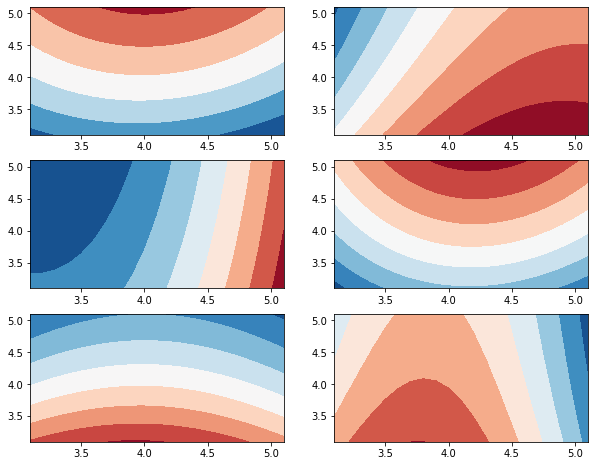

In [23]:
# Figure 5.
_,ax = plt.subplots(3,2,figsize=(10,8))
ax[0,0].contourf(m_t,m_e,np.array(L_coefs).reshape(len(thetas),-1),cmap = 'RdBu_r')
ax[0,1].contourf(m_t,m_e,np.array(w_coefs).reshape(len(thetas),-1),cmap = 'RdBu_r')
ax[1,0].contourf(m_t,m_e,np.array(P_coefs).reshape(len(thetas),-1),cmap = 'RdBu_r')
ax[1,1].contourf(m_t,m_e,np.array(R_coefs).reshape(len(thetas),-1),cmap = 'RdBu_r')
ax[2,0].contourf(m_t,m_e,np.array(RW_coefs).reshape(len(thetas),-1),cmap = 'RdBu_r')
ax[2,1].contourf(m_t,m_e,np.array(IU_coefs).reshape(len(thetas),-1),cmap = 'RdBu_r')


In [24]:
################### IRS setting ###################

# sigma - 1 = theta

In [25]:
from utils.recover_funds import solveHab
from utils.recover_funds import solveab


In [26]:
# Back out location fundamentals (a, b) using IRS model based on the initial equilibrium generated by the CRS model

x0 = np.random.uniform(size = NN*2).reshape(-1,2)
s_a, s_b = solveab(params, x0, L0, w0, H, dist0, LL,maxiter=1000, error = 1e-9)
Ha, Hb = solveHab(params, x0, L0, w0, H, dist0, LL,maxiter=1000, error=1e-9)



Current iteration: 100
Current iteration: 200
Unique location fundamentals found......
Current iteration: 100
Current iteration: 200
Unique solution found......


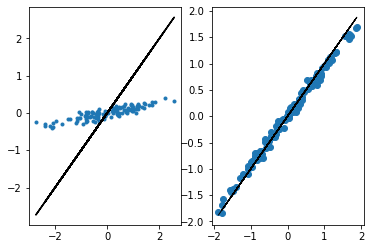

In [27]:
# Figure 6

_,ax = plt.subplots(1,2)
ax[0].scatter(x=np.log(a),y=np.log(Ha), marker='.')
ax[0].plot(np.log(a),np.log(a),color = 'k')
ax[1].scatter(x = np.log(b), y = np.log(Hb), marker='o',)
ax[1].plot(np.log(b),np.log(b),color = 'k',linewidth = 1)


In [28]:
Hfunds = [Ha, Hb, H]
HL0, Hw0, Hpi0 = utils.solve_Hlw(params, Hfunds, NN, dist0, LL,error = 1e-9)
HL1, Hw1, Hpi1 = utils.solve_Hlw(params, Hfunds, NN, dist1, LL,error=1e-9)

Current iteration: 100
Current iteration: 200
Unique solution found......
Current iteration: 100
Unique solution found......


In [29]:
HP0 = utils.Hprice_index([theta, Hsigma, F],a, Hpi0, Hw0, HL0)
HP1 = utils.Hprice_index([theta, Hsigma, F],a, Hpi1, Hw1, HL1)

In [30]:
Hr0 = utils.land_rent(alpha, H, Hw0, HL0)
Hr1 = utils.land_rent(alpha, H, Hw1, HL1)

In [31]:
Hrwage0 = utils.real_wage(alpha, Hw0, HP0, Hr0)
Hrwage1 = utils.real_wage(alpha, Hw1, HP1, Hr1)

In [32]:
Hpseudo_u = utils.pseudo_pwelfare([alpha, theta], Hpi0, Hpi1)

In [33]:


fig7data = pd.DataFrame(np.concatenate([HL1/HL0,Hrwage1/Hrwage0, HP1/HP0, Hw1/Hw0, Hr1/Hr0, Hpseudo_u.reshape(-1,1), treat.reshape(-1,1)],axis=1), 
                       columns=['Population','Real Wage','Price Index', 'Wage','Land Rents','Incorrect Immobile Welfare','treat'])

<Axes: xlabel='Incorrect Immobile Welfare', ylabel='Probability'>

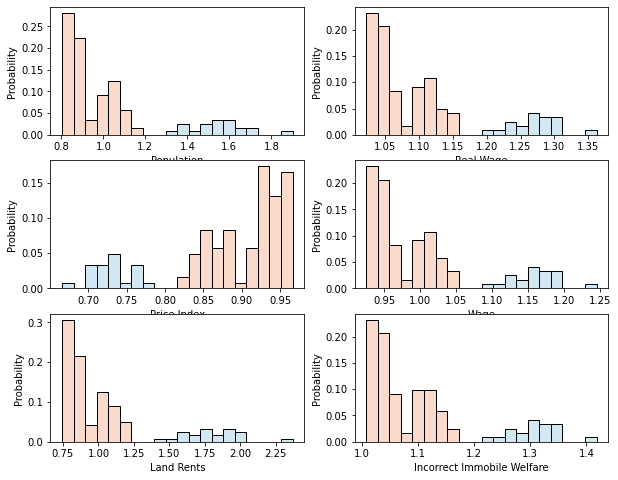

In [34]:
# replicate Figure 7

_,ax = plt.subplots(3,2,figsize=(10,8))

sns.histplot(data = fig7data, x='Population',ax=ax[0,0],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig7data, x='Real Wage',ax=ax[0,1],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig7data, x='Price Index',ax=ax[1,0],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)

sns.histplot(data = fig7data, x='Wage',ax=ax[1,1],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig7data, x='Land Rents',ax=ax[2,0],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)
sns.histplot(data = fig7data, x='Incorrect Immobile Welfare',ax=ax[2,1],stat = 'probability',legend=False,hue = 'treat',palette = 'RdBu',bins = 20)

# Define East and West

In [35]:
# Define east and west;
Iwest=np.zeros_like(tau0)
Ieast=np.zeros_like(tau0)
Iwest[:,:7] = 1
Ieast[:,7:] = 1

(-0.2, 4.2, -0.2, 4.2)

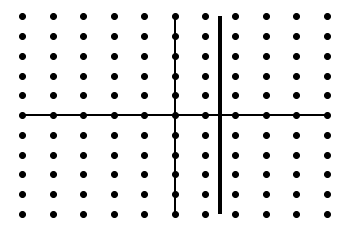

In [36]:
# replicate Figure 8
x,y = np.meshgrid(ltd,lgd)
_,ax = plt.subplots()
ax.scatter(x=x,y =y,color = 'k')
ax.vlines(x = 2, ymin = 0, ymax = 4,color = 'k', linewidth = 2)
ax.vlines(x = 2.6, ymin = 0, ymax = 4,color = 'k', linewidth = 4)
ax.hlines(y = 2, xmin = 0, xmax = 4,color = 'k',linewidth = 2)
ax.axis("off")

In [37]:
# Define east and west
Iwest=np.zeros_like(tau0)
Ieast=np.zeros_like(tau0)
Iwest[:,:7] = 1
Ieast[:,7:] = 1


west_idx = Iwest.ravel() == 1
east_idx = Ieast.ravel() == 1

# open economies, trade is allowed
dopen=np.ones_like(dist0)

# closed economies, trade is NOT allowed
dclosed=np.zeros_like(dist0)
dclosed[np.ix_(west_idx, west_idx)] = 1
dclosed[np.ix_(east_idx, east_idx)] = 1

In [38]:
# Labor is immobile between countries and perfectly mobile within the country

LLwest=np.sum(Iwest)/NN*LL
LLeast=np.sum(Ieast)/NN*LL



In [39]:
from utils.country_utils import solvewl_country

In [40]:

closedL, closedw, closedpi = solvewl_country(params, Iwest, Ieast,funds, dist1, dclosed, LLwest, LLeast, NN)



Current iteration =  0
Current iteration =  200
Unique solution found......


In [41]:
openL, openw, openpi = solvewl_country(params, Iwest, Ieast,funds, dist1, dopen, LLwest, LLeast, NN)

Current iteration =  0
Unique solution found......


In [42]:
closedP = utils.price_index([alpha, theta, sigma], funds, closedpi,closedw)
openP = utils.price_index([alpha, theta, sigma], funds, openpi,openw)

In [43]:

# land rent
closedr = utils.land_rent(alpha, H, closedw,closedL)
openr = utils.land_rent(alpha, H, openw,openL)



In [44]:
closedrwage = utils.real_wage(alpha, closedw, closedP,closedr)
openrwage = utils.real_wage(alpha, openw, openP, openr)

In [45]:
oc_psuedo_welfare = utils.pseudo_pwelfare([alpha, theta], closedpi,openpi)

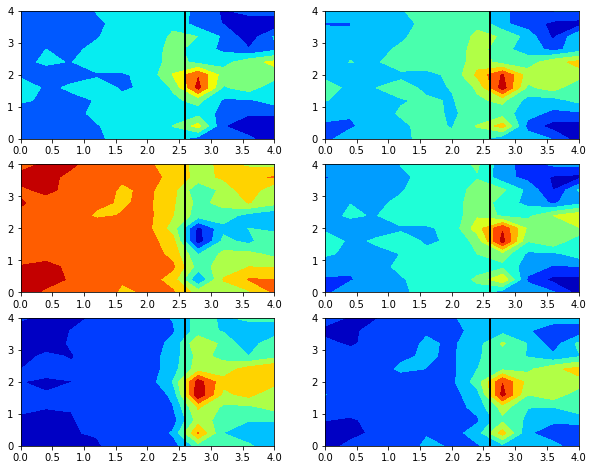

In [46]:
# replicate Figure 9.

_,ax = plt.subplots(3,2,figsize=(10,8))
ax[0,0].contourf(x,y,(openL/closedL).reshape(N,N),cmap = 'jet')
ax[0,0].vlines(x = 2.6, ymin = 0, ymax = 4,color = 'k', linewidth = 2)
ax[0,1].contourf(x,y,(openw/closedw).reshape(N,N),cmap = 'jet')
ax[0,1].vlines(x = 2.6, ymin = 0, ymax = 4,color = 'k', linewidth = 2)
ax[1,0].contourf(x,y,(openP/closedP).reshape(N,N),cmap = 'jet')
ax[1,0].vlines(x = 2.6, ymin = 0, ymax = 4,color = 'k', linewidth = 2)
ax[1,1].contourf(x,y,(openr/closedr).reshape(N,N),cmap = 'jet')
ax[1,1].vlines(x = 2.6, ymin = 0, ymax = 4,color = 'k', linewidth = 2)
ax[2,0].contourf(x,y,(openrwage/closedrwage).reshape(N,N),cmap = 'jet')
ax[2,0].vlines(x = 2.6, ymin = 0, ymax = 4,color = 'k', linewidth = 2)
ax[2,1].contourf(x,y,(oc_psuedo_welfare).reshape(N,N),cmap = 'jet')
ax[2,1].vlines(x = 2.6, ymin = 0, ymax = 4,color = 'k', linewidth = 2)


In [47]:


fig10data = pd.DataFrame(np.concatenate([openL/closedL,openrwage/closedrwage, openP/closedP, openw/closedw, openr/closedr,oc_psuedo_welfare.reshape(-1,1), Iwest.reshape(-1,1)],axis=1), 
                       columns=['Population','Real Wage','Price Index', 'Wage','Land Rents','Incorrect Immobile Welfare','west'])

<Axes: xlabel='Incorrect Immobile Welfare', ylabel='Probability'>

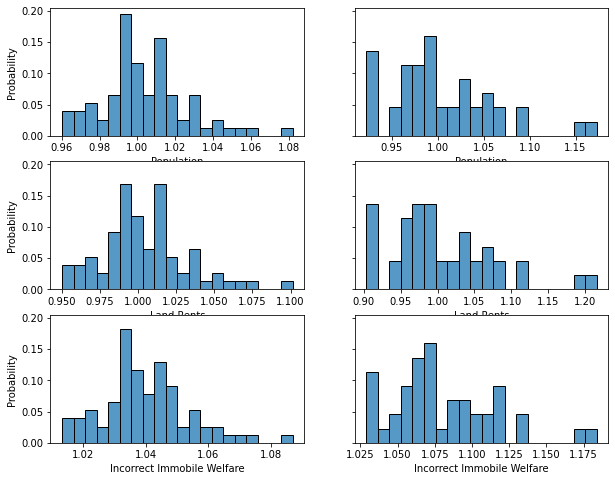

In [48]:
# replicate Figure 10

_,ax = plt.subplots(3,2,figsize=(10,8),sharey=True)
sns.histplot(data = fig10data.query('west==1'), x='Population',ax=ax[0,0],stat = 'probability',legend=False,bins=20)
sns.histplot(data = fig10data.query('west==0'), x='Population',ax=ax[0,1],stat = 'probability',legend=False,bins=20)
sns.histplot(data = fig10data.query('west==1'), x='Land Rents',ax=ax[1,0],stat = 'probability',legend=False,bins=20)
sns.histplot(data = fig10data.query('west==0'), x='Land Rents',ax=ax[1,1],stat = 'probability',legend=False,bins=20)
sns.histplot(data = fig10data.query('west==1'), x='Incorrect Immobile Welfare',ax=ax[2,0],stat = 'probability',legend=False,bins=20)
sns.histplot(data = fig10data.query('west==0'), x='Incorrect Immobile Welfare',ax=ax[2,1],stat = 'probability',legend=False,bins=20)

In [49]:
# Table 1

crs_coef = []

lm = sm.OLS(np.log(L1) - np.log(L0), sm.add_constant(treat))
crs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(w1) - np.log(w0), sm.add_constant(treat))
crs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(P1) - np.log(P0), sm.add_constant(treat))
crs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(r1) - np.log(r0), sm.add_constant(treat))
crs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(realw1) - np.log(realw0), sm.add_constant(treat))
crs_coef.append(lm.fit().params[1])
lm = sm.OLS(pseudo_u, sm.add_constant(treat))
crs_coef.append(lm.fit().params[1])


irs_coef = []

lm = sm.OLS(np.log(HL1) - np.log(HL0), sm.add_constant(treat))
irs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(Hw1) - np.log(Hw0), sm.add_constant(treat))
irs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(HP1) - np.log(HP0), sm.add_constant(treat))
irs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(Hr1) - np.log(Hr0), sm.add_constant(treat))
irs_coef.append(lm.fit().params[1])
lm = sm.OLS(np.log(Hrwage1) - np.log(Hrwage0), sm.add_constant(treat))
irs_coef.append(lm.fit().params[1])
lm = sm.OLS(Hpseudo_u, sm.add_constant(treat))
irs_coef.append(lm.fit().params[1])



In [50]:
# Coef. for CRS model
crs_coef

[0.38211040024396076,
 0.08238475806944429,
 -0.18751734875403792,
 0.5361762124001506,
 0.1273701334146539,
 0.2646883675778838]

In [51]:
# Coef. for IRS model
irs_coef

[0.5200108873925063,
 0.1797568499628338,
 -0.2246960624535613,
 0.69976773735534,
 0.17333696246416963,
 0.24292350164390486]